# MindSpore Challenge Tutorial (Intermediate)

Throughout this tutorial we will cover [MindSpore](https://www.mindspore.cn/doc/api_python/en/r1.2/index.html)'s common modules
- OBS downloading and preprocessing the first dataset, `dataset_1`
- Training and creating MindSpore Models (YoloV3).
- ModelArts as our platform for training this model, 
- Submission onto MindSpore Challenge 21 portal.

Prerequisite:
- Understanding of Python and Python common packages
- Understanding of operations and  of common machine learning libraries.
- Understanding of designing, training, evaluation of machine learning libraries.

We will be referencing from [MindSpore Course](https://github.com/mindspore-ai/course)'s YoloV3 project

[ms dataset]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.dataset.html
[ms nn]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.nn.html
[ms ops]: https://www.mindspore.cn/doc/api_python/en/r1.2/mindspore/mindspore.ops.html

## Obtaining notebook https://github.com/MindSporeChallenge21/resources
Visit the link above to download this notebook so you can try on your own.

## Importing Libraries

In [1]:
import os
import argparse
import time
from pathlib import Path
import json
from copy import copy

import pandas as pd
import numpy as np
from easydict import EasyDict as ed
from scipy import interpolate

import requests

import cv2
import PIL
from PIL import Image

from matplotlib import pyplot as plt

import mindspore as ms 
from mindspore import dataset
from mindspore import context, Tensor

In [2]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")
# context.set_context(mode=context.PYNATIVE_MODE, device_target="Ascend")

\* For debugging of the model you may use the PYNATIVE_MODE

## Importing Data and Utilities Sources

The first dataset, `dataset_1` can be obtained from Huawei Cloud's OBS through:
> http://mspdc-testing-bucket2.obs.cn-north-4.myhuaweicloud.com/dataset.zip

In [3]:
!mkdir -p datasets/MSC21_Data
!wget -nc http://mspdc-testing-bucket2.obs.cn-north-4.myhuaweicloud.com/dataset.zip -P datasets/MSC21_Data
!unzip -qqo ./datasets/MSC21_Data/dataset.zip -d ./datasets/MSC21_Data/

File ‘datasets/MSC21_Data/dataset.zip’ already there; not retrieving.



We can create the database object.

In [4]:
dataset_path = Path('datasets') / 'MSC21_Data' / 'dataset'
label_path = dataset_path / 'labels.csv'
images_path = dataset_path / 'images'

mindrecord_path = Path('datasets') / 'MSC21_Data' / 'mindrecord'
mindrecord_train_path = mindrecord_path / 'train'
mindrecord_train_file_path = mindrecord_train_path / "yolo.mindrecord"

mindrecord_test_path = mindrecord_path / 'test'
mindrecord_test_file_path = mindrecord_test_path / "yolo.mindrecord"

mindrecord_path.mkdir(parents=True, exist_ok=True)
mindrecord_train_path.mkdir(parents=True, exist_ok=True)
mindrecord_test_path.mkdir(parents=True, exist_ok=True)

In [5]:
!git clone https://github.com/MindSporeChallenge21/msc21_yolo_example.git src

fatal: destination path 'src' already exists and is not an empty directory.


The size of the example image is: (837, 1440, 3)


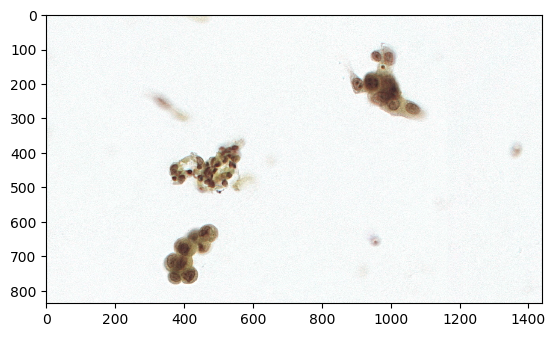

In [6]:
example_image = cv2.imread(
    str(images_path / 'sample_0000.bmp')
)
print(f'The size of the example image is: {example_image.shape}')
plt.imshow(example_image)
plt.show()

We define a configuration object, which will be useful for hyperparameter tuning.

In [28]:
cfg = ed({
    "distribute": False,
    "device_id": 0,
    "device_num": 1,
    "dataset_sink_mode": True,

    "lr": 0.01,
    "epoch_size": 30,
    "batch_size": 8,
    "loss_scale" : 1024,

    "pre_trained": None,
    "pre_trained_epoch_size":0,

    "ckpt_dir": "./ckpt",
    "save_checkpoint_epochs" :1,
    'keep_checkpoint_max': 1,

}) 

## Creating MindSpore Dataset

We can use [mindspore.dataset.GeneratorDataset](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/dataset/mindspore.dataset.GeneratorDataset.html#mindspore.dataset.GeneratorDataset) or [mindspore.dataset.NumpySlicesDataset](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/dataset/mindspore.dataset.NumpySlicesDataset.html#mindspore.dataset.NumpySlicesDataset) to read data, 

But in our case we will create a **MindRecord** so it's easier to read the whole dataset later.

We will used the code from the repository.

In [29]:
# creating a Mindrecord. 
import src.dataset as msc21_dataset
from src import config
ConfigYOLOV3ResNet18 = config.ConfigYOLOV3ResNet18

import numpy as np
import mindspore.nn as nn
from mindspore import context, Tensor
from mindspore.communication.management import init
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.context import ParallelMode
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.common.initializer import initializer
from mindspore.common import set_seed

prefix = "yolo.mindrecord"

# We only create this MindRecord if it does not exists.
if not (Path(mindrecord_train_path) / prefix).exists():
    msc21_dataset.data_to_mindrecord_byte_image(images_path, mindrecord_path, prefix, 1, label_path, train_test_split=0.95)

A MindRecord is created by a [FileWriter](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/mindspore.mindrecord.html#mindspore.mindrecord.FileWriter). 

We then describing the schema(format) of the dataset, and each datapoints can be write into the FileWriter. 

Finally we can output this writer with `.commit()` function.

A `dataset` object is like a collections of datapoints. Each `dataset` object have the `key` or `columns` which exists for each datapoint.

As mentioned before you can use `dataset.get_col_names()` to get the column names, and the `labels` of the data is the **last column of the `dataset` object** therefore the sequence of the dataset columns is important .

After constructing the dataset you can choose what `batch_size` to created batches for training the models with the `.batch()` function, the columns of the dataset will remains unchanged after batching, just that each column now have one extra dimension ecapsulating a batch of datapoints.

## Dataset Preprocessing

While preprocessing the dataset you are encouraged to use the `dataset.map()` function. 
Using the map operations can speed up the processing on the ModelArts.

The [map](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/dataset/mindspore.dataset.MindDataset.html#mindspore.dataset.MindDataset.map) function takes in a list of `operations`, the choosen `input_columns` and the `output_columns`.

The `operations` can be MindSpore's Tensor operation such as `HWC2CHW`, `Decode`, `Rescale` or just python functions.
There are plenty of helpful function that can help you preprocess your dataset easier [here](https://www.mindspore.cn/doc/api_python/zh-CN/r1.2/mindspore/dataset/mindspore.dataset.MindDataset.html#mindspore.dataset.MindDataset).

In our case the implementation is in the `dataset.py` we will use its' function here.

In [30]:
# We reads the MindRecord file and create a mindspore dataset object from it.
dataset = msc21_dataset.create_yolo_dataset(
    str(mindrecord_train_file_path),
    batch_size=cfg.batch_size
)
dataset_size = dataset.get_dataset_size()
print('The epoch size: ', dataset_size)
print("Create dataset done!")

The epoch size:  27
Create dataset done!


## Network Initialisation

We will use the same way to create a MindSpore model, here we import our network architecture from the `yolov3.py`. The `yolov3_resnet18` class is a `nn.Cell` extension, it uses Resnet-18 as the backbone of the Yolov3.

The `YoloWithLossCell` includes the loss function calculation into the network, this will allow us to calculate the loss faster, because its compiled into the network. Therefore there should not be any learnable parameters in the second part of the network. Later, we will detach this part of the network when we are doing inference.

In [31]:
from src.yolov3 import yolov3_resnet18, YoloWithLossCell, TrainingWrapper
net = yolov3_resnet18(ConfigYOLOV3ResNet18())
net = YoloWithLossCell(net, ConfigYOLOV3ResNet18())

def init_net_param(network, init_value='ones'):
    """Init the parameters in network."""
    params = network.trainable_params()
    for p in params:
        if isinstance(p.data, ms.Tensor) and 'beta' not in p.name and 'gamma' not in p.name and 'bias' not in p.name:
            p.set_data(initializer(init_value, p.data.shape, p.data.dtype))

init_net_param(net, "XavierUniform")

[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-07:52:57.793.114 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-07:52:57.821.347 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-07:52:57.875.898 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-07:52:57.928.833 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-07:52:58.814.30 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated fro

## Defining the Model

In the previous tutorial we have shown how to define a Model, here we will use a more advance method to calculate learning rate, and we will handle the gradient update on our own, indeed the parameter `loss_fn`(loss) and `optimizer` in `mindspore.Model` is optional.

In this case we first gives the optimizer(Adam) the network parameters. Then at the `TrainingWrapper`'s `construct` function, we will first calculate the gradient, by using the GradOperation function, we then use this gradient to put into the optimizer so that it can update the parameters.

the `get_lr` function will calculate what learning rate to give to the model at each step.

You can also use the `mindspore.train.callback.ModelCheckpoint` to save the checkpoint at each stage of learning.

Then we uses `model.train()` to train the model.

In [32]:

def get_lr(learning_rate, start_step, global_step, decay_step, decay_rate, steps=False):
    """Set learning rate."""
    lr_each_step = []
    for i in range(global_step):
        if steps:
            lr_each_step.append(learning_rate * (decay_rate ** (i // decay_step)))
        else:
            lr_each_step.append(learning_rate * (decay_rate ** (i / decay_step)))
    lr_each_step = np.array(lr_each_step).astype(np.float32)
    lr_each_step = lr_each_step[start_step:]
    return lr_each_step

# checkpoint
ckpt_config = CheckpointConfig(
    save_checkpoint_steps=dataset_size * cfg.save_checkpoint_epochs,
    keep_checkpoint_max=cfg.keep_checkpoint_max
)

ckpoint_cb = ModelCheckpoint(prefix="yolov3", directory=cfg.ckpt_dir, config=ckpt_config)

total_epoch_size = 30
loss_scale = float(cfg.loss_scale)

lr = ms.Tensor(get_lr(learning_rate=cfg.lr, start_step=cfg.pre_trained_epoch_size * dataset_size,
                   global_step=total_epoch_size * dataset_size,
                   decay_step=1000, decay_rate=0.95, steps=True))
opt = nn.Adam(filter(lambda x: x.requires_grad, net.get_parameters()), lr, loss_scale=loss_scale)
net = TrainingWrapper(net, opt, loss_scale)

callback = [LossMonitor(10*dataset_size), ckpoint_cb]
model = Model(net)
dataset_sink_mode = cfg.dataset_sink_mode
print("Start train YOLOv3, the first epoch will be slower because of the graph compilation.")
model.train(cfg.epoch_size, dataset, callbacks=callback, dataset_sink_mode=dataset_sink_mode)

Start train YOLOv3, the first epoch will be slower because of the graph compilation.
epoch: 10 step: 27, loss is 72.6983
epoch: 20 step: 27, loss is 31.487173
epoch: 30 step: 27, loss is 26.163595


## Inference

In this stage we will:
1. read network from checkpoint file.
2. use dataset to test network.
3. deconstruct result from network into actual bounding boxes.
4. visualises the result.

In [34]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net

from src.yolov3 import yolov3_resnet18, YoloWithEval
from src.dataset import create_yolo_dataset, data_to_mindrecord_byte_image
from src.config import ConfigYOLOV3ResNet18
from src.utils import metrics

def apply_nms(all_boxes, all_scores, thres, max_boxes):
    """
    Apply NMS to bboxes.
    
    NMS chooses omits bounding boxes with iou > threshold and;
    chooses the one with highest confidence
    
    """
    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    order = all_scores.argsort()[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)

        if len(keep) >= max_boxes:
            break

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thres)[0]

        order = order[inds + 1]
    return keep


def tobox(boxes, box_scores):
    """
    Make results become boxes.
    1. classify results by classes
        - if confidence > threshold, accepts it as mask = 1
        - with masks we can classify them 
    2. filter boxes, keep highest confidence.
    """
    config = ConfigYOLOV3ResNet18()
    num_classes = config.num_classes
    mask = box_scores >= (config.obj_threshold*0.2)
    boxes_ = []
    scores_ = []
    classes_ = []
    max_boxes = config.nms_max_num
    for c in range(num_classes):
        class_boxes = np.reshape(boxes, [-1, 4])[np.reshape(mask[:, c], [-1])]
        class_box_scores = np.reshape(box_scores[:, c], [-1])[np.reshape(mask[:, c], [-1])]
        nms_index = apply_nms(class_boxes, class_box_scores, config.nms_threshold, max_boxes)
        #nms_index = apply_nms(class_boxes, class_box_scores, 0.5, max_boxes)
        class_boxes = class_boxes[nms_index]
        class_box_scores = class_box_scores[nms_index]
        classes = np.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)

    boxes = np.concatenate(boxes_, axis=0)
    classes = np.concatenate(classes_, axis=0)
    scores = np.concatenate(scores_, axis=0)

    return boxes, classes, scores
  

In [39]:
cfg = ed({})

# find the filename for the CKPT using the explorer
CKPT_FILENAME = "yolov3_3-30_27.ckpt"

ckpt_path = './ckpt/'
cfg.ckpt_path = os.path.join(ckpt_path, CKPT_FILENAME) 
# depending on how many epoches is trained and what is the batch size this name will change.

if not (Path(mindrecord_train_path) / prefix).exists():
    msc21_dataset.data_to_mindrecord_byte_image(images_path, mindrecord_path, prefix, 1, label_path, train_test_split=0.8)


In [40]:
# creating the dataset object
dataset = msc21_dataset.create_yolo_dataset(
    str(mindrecord_test_file_path),
    batch_size=1,
    is_training=False
)

# setting up network
config = ConfigYOLOV3ResNet18()
net = yolov3_resnet18(config)
eval_net = YoloWithEval(net, config)

[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-08:00:45.497.22 [mindspore/dataset/engine/datasets.py:3063] WARN: global shuffle is not used.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-08:00:45.985.69 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-08:00:45.128.260 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-08:00:45.187.099 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(30513:281473411960416,MainProcess):2021-08-25-08:00:45.244.310 [mindspore/common/_decorator.py:32] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Ad

Next we can load the checkpoint files

In [41]:
param_dict = load_checkpoint(cfg.ckpt_path)
load_param_into_net(net, param_dict)
eval_net.set_train(False);

use `Net.set_train(False)` to enter inference mode.

## Visualisation

We will draw out the predicted bounding boxes.



total images num:  11
Processing, please wait a moment.


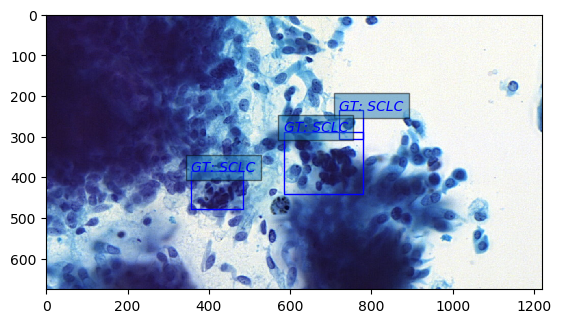

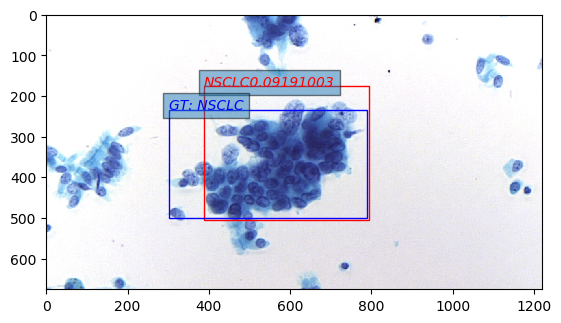

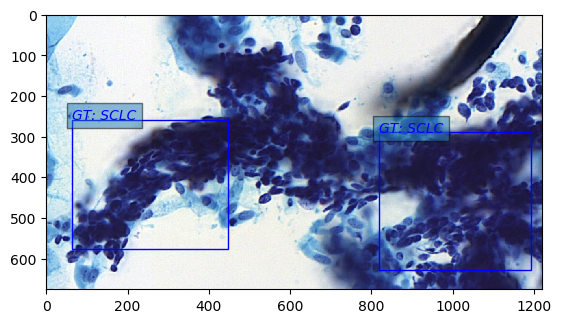

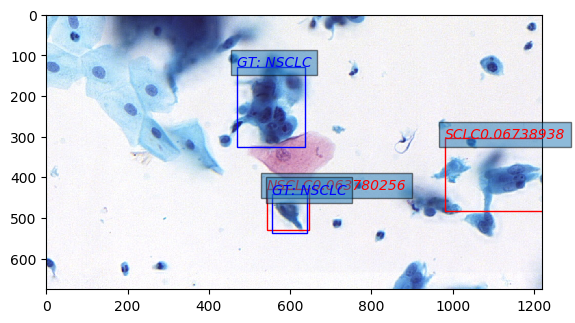

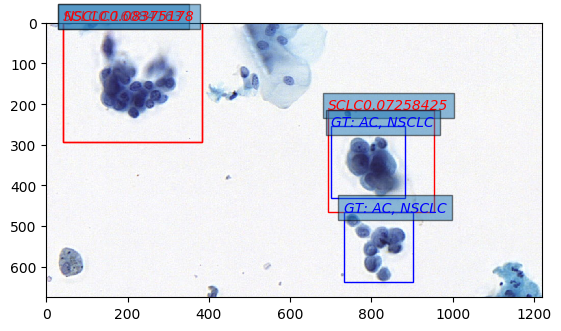

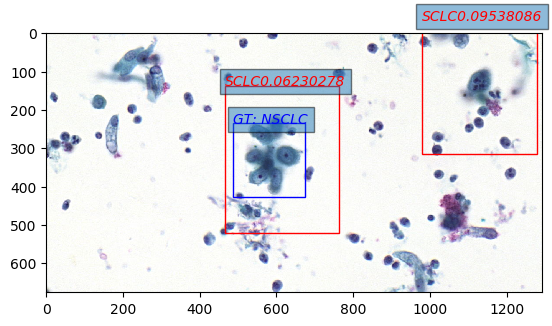

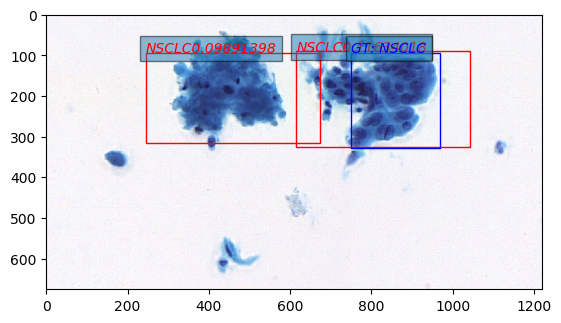

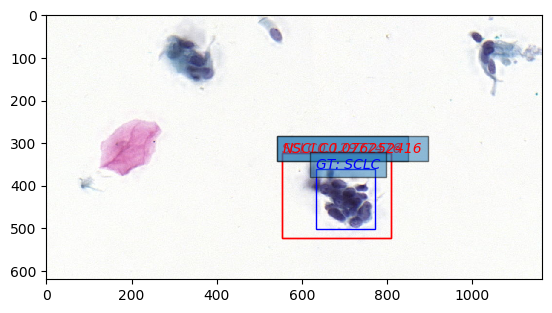

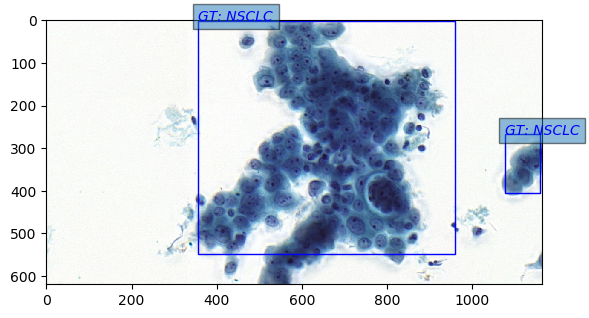

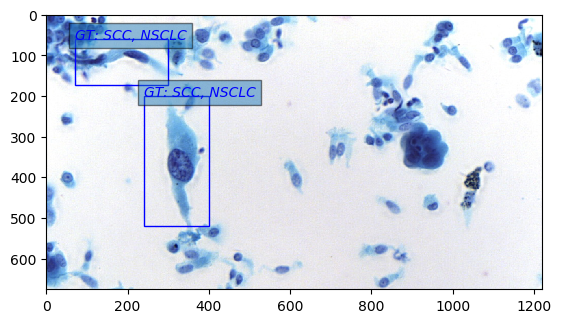

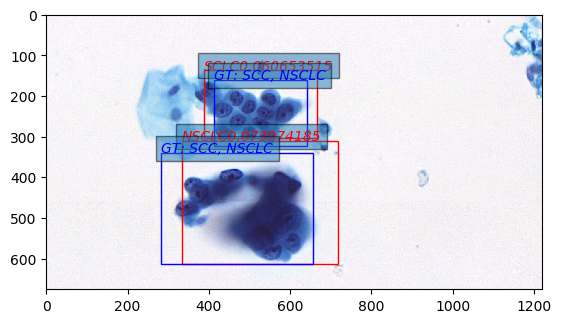

In [42]:
total = dataset.get_dataset_size()
pred_data = []
print("\n========================================\n")
print("total images num: ", total)
print("Processing, please wait a moment.")

num_class={0:'SCC', 1: 'AC', 2:'SCLC', 3: 'NSCLC'}

for data in dataset.create_dict_iterator(output_numpy=True):
    
    # destruct variables
    img_np = data['image']
    image_shape = data['image_shape']
    annotation = data['annotation']
    image_file = data['file']
    image_file = image_file.tostring().decode('ascii')

    # using the network
    output = eval_net(ms.Tensor(img_np), ms.Tensor(image_shape))
    
    
    for batch_idx in range(img_np.shape[0]):
        
        # destruct variables
        boxes = output[0].asnumpy()[batch_idx]
        box_scores = output[1].asnumpy()[batch_idx]
        image = img_np[batch_idx,...]
        boxes, classes, scores = tobox(boxes, box_scores)
        
        # creating a plot
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        # draw image
        image_path = images_path / image_file
        f = Image.open(image_path) 
        img_np = np.asarray(f ,dtype=np.float32)
        ax.imshow(img_np.astype(np.uint8))

        # draw prediction
        for box_index in range(boxes.shape[0]):
            ymin=boxes[box_index][0]
            xmin=boxes[box_index][1]
            ymax=boxes[box_index][2]
            xmax=boxes[box_index][3]
            ax.add_patch(plt.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,edgecolor='red', linewidth=1))
            ax.text(xmin,ymin,s = str(num_class[classes[box_index]])+str(scores[box_index]),
                    style='italic', c ='red', bbox={'alpha': 0.5})
        
        # draw ground truth
        for anno in annotation:
            xmin=anno[0]
            ymin=anno[1]
            xmax=anno[2]
            ymax=anno[3]
            ax.add_patch(plt.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,edgecolor='blue', linewidth=1))
            labels = []
            for class_ in num_class:
                if anno[class_ - 4] > 0:
                    labels += [num_class[class_]]
            labels = ', '.join(labels)
            ax.text(xmin, ymin, s = 'GT: ' +labels,
                    style='italic', c = 'blue',bbox={'alpha': 0.5})
        plt.show()

We can then submit into the portal to be tested on ModelArts.

We can also copy the files to our OBS.

In [33]:
# import moxing as mox
# mox.file.copy_parallel('ckpt', 'obs://msc21-tutor-dev/example/yolo/ckpt')

INFO:root:Using MoXing-v1.17.3-d858ff4a
INFO:root:Using OBS-Python-SDK-3.20.9.1
